Import Packages

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency
import warnings

Load Clean Data

In [47]:
# Load the dataset
df = pd.read_csv("Salmonella_enterica_cleaned.csv")

Prep AMR and taxonomic data

In [48]:

def prepare_amr_taxonomy_data(df):
    """Extract AMR genes and prepare serovar"""
    
    required_cols = ['AMR genotypes', 'Serovar']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f" Missing columns: {missing_cols}")
        return None
    
    # Extract AMR genes
    def extract_amr_genes(amr_string):
        if pd.isna(amr_string):
            return []
        genes = []
        for part in str(amr_string).split(','):
            if '=' in part:
                gene = part.split('=')[0].strip()
                genes.append(gene)
        return genes
    
    def extract_amr_status(amr_string):
        if pd.isna(amr_string):
            return {}
        status_dict = {}
        for part in str(amr_string).split(','):
            if '=' in part and len(part.split('=')) >= 2:
                gene, status = part.split('=', 1)
                status_dict[gene.strip()] = status.strip()
        return status_dict
    
    # Process data
    df_analysis = df.copy()
    df_analysis['AMR_genes'] = df_analysis['AMR genotypes'].apply(extract_amr_genes)
    df_analysis['AMR_status'] = df_analysis['AMR genotypes'].apply(extract_amr_status)
    df_analysis['AMR_count'] = df_analysis['AMR_genes'].apply(len)
    
    # Clean up serovar and strain data
    df_analysis['Serovar_clean'] = df_analysis['Serovar'].fillna('Unknown').astype(str).str.strip()
    df_analysis['Strain_clean'] = df_analysis['Strain'].fillna('Unknown').astype(str).str.strip()
    
    # Get all unique AMR genes
    all_genes = []
    for genes in df_analysis['AMR_genes']:
        all_genes.extend(genes)
    
    gene_counts = Counter(all_genes)
    unique_genes = list(gene_counts.keys())
    
    print(f" Data Summary:")
    print(f"   Total AMR genes found: {len(unique_genes)}")
    print(f"   Unique serovars: {df_analysis['Serovar_clean'].nunique()}")
    print(f"   Unique strains: {df_analysis['Strain_clean'].nunique()}")
    print(f"   Samples with AMR genes: {(df_analysis['AMR_count'] > 0).sum()}")
    
    print(f"\n Top 15 AMR genes:")
    for i, (gene, count) in enumerate(gene_counts.most_common(15), 1):
        percentage = (count / len(df_analysis)) * 100
        print(f"   {i:2d}. {gene}: {count} samples ({percentage:.1f}%)")
    
    return df_analysis, unique_genes, gene_counts

df_amr, all_amr_genes, gene_frequency = prepare_amr_taxonomy_data(df)

if df_amr is None:
    exit()

 Data Summary:
   Total AMR genes found: 458
   Unique serovars: 2472
   Unique strains: 241194
   Samples with AMR genes: 263453

 Top 15 AMR genes:
    1. mdsB: 252425 samples (93.0%)
    2. mdsA: 252203 samples (92.9%)
    3. aph(3'')-Ib: 42510 samples (15.7%)
    4. aph(6)-Id: 41187 samples (15.2%)
    5. tet(A): 38306 samples (14.1%)
    6. sul2: 34894 samples (12.9%)
    7. sul1: 33981 samples (12.5%)
    8. blaTEM-1: 28688 samples (10.6%)
    9. tet(B): 23531 samples (8.7%)
   10. aadA1: 21361 samples (7.9%)
   11. floR: 17397 samples (6.4%)
   12. gyrA_D87Y: 16768 samples (6.2%)
   13. fosA7: 13634 samples (5.0%)
   14. gyrA_S83F: 11584 samples (4.3%)
   15. aadA2: 11141 samples (4.1%)


Gene vs Serovar

In [49]:
def analyze_amr_by_serovar(df_amr, genes, min_samples=10):
    """Analyze AMR gene distribution by serovar"""
    
    print("\n" + "="*60)
    print(" AMR GENES BY SEROVAR ANALYSIS")
    print("="*60)
    
    # Get serovars with sufficient samples
    serovar_counts = df_amr['Serovar_clean'].value_counts()
    common_serovars = serovar_counts[serovar_counts >= min_samples].index.tolist()
    
    print(f" Analyzing {len(common_serovars)} serovars with {min_samples}+ samples:")
    for serovar in common_serovars[:10]:
        print(f"   {serovar}: {serovar_counts[serovar]} samples")
    if len(common_serovars) > 10:
        print(f"   ... and {len(common_serovars)-10} more")
    
    # Create serovar-gene association matrix
    serovar_gene_data = []
    
    for serovar in common_serovars:
        serovar_samples = df_amr[df_amr['Serovar_clean'] == serovar]
        total_samples = len(serovar_samples)
        
        serovar_info = {
            'serovar': serovar,
            'total_samples': total_samples,
            'amr_samples': (serovar_samples['AMR_count'] > 0).sum(),
            'avg_amr_genes': serovar_samples['AMR_count'].mean()
        }
        
        # Calculate gene prevalence for top genes
        for gene in genes[:30]:  # Top 30 genes for analysis
            gene_count = sum(1 for sample_genes in serovar_samples['AMR_genes'] if gene in sample_genes)
            serovar_info[f'{gene}_count'] = gene_count
            serovar_info[f'{gene}_prevalence'] = (gene_count / total_samples) * 100
        
        serovar_gene_data.append(serovar_info)
    
    serovar_amr_df = pd.DataFrame(serovar_gene_data)
    
    # Find top associations
    print(f"\n TOP SEROVAR-AMR GENE ASSOCIATIONS:")
    
    top_genes_for_analysis = [gene for gene, count in gene_frequency.most_common(20)]
    
    for gene in top_genes_for_analysis[:10]:
        gene_serovar = serovar_amr_df.nlargest(5, f'{gene}_prevalence')[['serovar', f'{gene}_prevalence', f'{gene}_count', 'total_samples']]
        print(f"\n   {gene} (most common in):")
        for _, row in gene_serovar.iterrows():
            if row[f'{gene}_prevalence'] > 0:
                print(f"     {row['serovar']}: {row[f'{gene}_prevalence']:.1f}% ({row[f'{gene}_count']}/{row['total_samples']} samples)")
    
    return serovar_amr_df, common_serovars

serovar_analysis_df, common_serovars = analyze_amr_by_serovar(df_amr, list(gene_frequency.keys()))


 AMR GENES BY SEROVAR ANALYSIS
 Analyzing 545 serovars with 10+ samples:
   Enteritidis: 37272 samples
   Typhimurium: 33149 samples
   enteritidis: 12532 samples
   Infantis: 12348 samples
   Typhi: 10741 samples
   Newport: 9647 samples
   Kentucky: 8297 samples
   Heidelberg: 4892 samples
   Salmonella enterica subsp. enterica serovar Infantis: 4448 samples
   Salmonella Typhimurium - monophasic: 4015 samples
   ... and 535 more

 TOP SEROVAR-AMR GENE ASSOCIATIONS:

   mdsB (most common in):
     Salmonella enterica subsp. enterica serovar Infantis: 100.0% (4448/4448 samples)
     Reading: 100.0% (1800/1800 samples)
     Virchow: 100.0% (1525/1525 samples)
     Salmonella enterica subsp. enterica serovar Enteritidis: 100.0% (1501/1501 samples)
     Salmonella enterica subsp. enterica serovar Anatum: 100.0% (1117/1117 samples)

   mdsA (most common in):
     Salmonella enterica subsp. enterica serovar Infantis: 100.0% (4448/4448 samples)
     Agona: 100.0% (3857/3857 samples)
     S

Visualise serovar AMR

<Figure size 2000x1000 with 0 Axes>

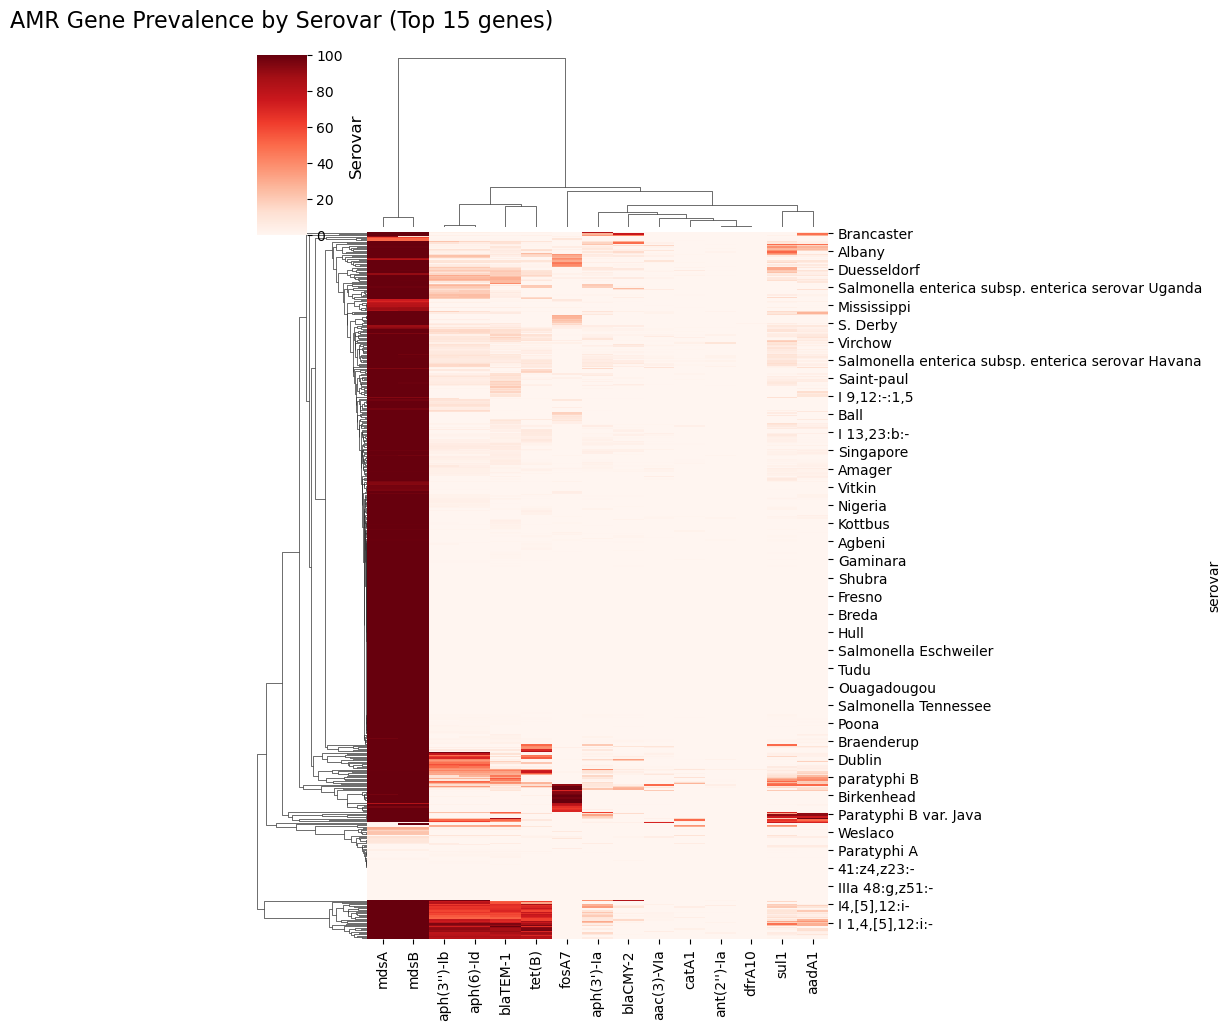

In [50]:
def create_serovar_amr_heatmaps(serovar_df, top_genes=15):
    
    # Prepare data for heatmap
    gene_cols = [f'{gene}_prevalence' for gene in list(gene_frequency.keys())[:top_genes]]
    existing_cols = [col for col in gene_cols if col in serovar_df.columns]
    
    heatmap_data = serovar_df[['serovar'] + existing_cols].set_index('serovar')
    heatmap_data.columns = [col.replace('_prevalence', '') for col in heatmap_data.columns]
    
    # Sort by total AMR burden
    heatmap_data['total_burden'] = heatmap_data.sum(axis=1)
    heatmap_data = heatmap_data.sort_values('total_burden', ascending=False)
    heatmap_data = heatmap_data.drop('total_burden', axis=1)
    
    # Create heatmap
    plt.figure(figsize=(20, 10))
    sns.clustermap(
        heatmap_data,
        cmap='Reds'
    )
    
    plt.title(f'AMR Gene Prevalence by Serovar (Top {top_genes} genes)', fontsize=16, pad=20)
    plt.xlabel('AMR Genes', fontsize=12)
    plt.ylabel('Serovar', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
    
    return heatmap_data

serovar_heatmap = create_serovar_amr_heatmaps(serovar_analysis_df)

Stats


In [51]:
def perform_statistical_analysis(df_amr, top_genes=10):
    """Perform statistical tests for gene-serovar associations"""
    
    print("\n" + "="*60)
    print("📈 STATISTICAL ASSOCIATION ANALYSIS")
    print("="*60)
    
    top_genes_list = [gene for gene, count in gene_frequency.most_common(top_genes)]
    top_serovars = df_amr['Serovar_clean'].value_counts().head(10).index.tolist()
    
    significant_associations = []
    
    print("🔬 Chi-square tests for independence (p < 0.05 indicates significant association):")
    
    for gene in top_genes_list:
        for serovar in top_serovars:
            # Create contingency table
            df_test = df_amr[df_amr['Serovar_clean'].isin([serovar, 'Other'])]
            df_test.loc[~df_test['Serovar_clean'].isin([serovar]), 'Serovar_clean'] = 'Other'
            
            # Gene present/absent by serovar
            df_test['gene_present'] = df_test['AMR_genes'].apply(lambda x: gene in x)
            
            contingency = pd.crosstab(df_test['Serovar_clean'], df_test['gene_present'])
            
            if contingency.shape == (2, 2) and contingency.min().min() >= 5:  # Valid chi-square test
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                
                if p_value < 0.05:
                    # Calculate association strength (Cramér's V)
                    n = contingency.sum().sum()
                    cramers_v = np.sqrt(chi2 / (n * min(contingency.shape) - 1))
                    
                    # Get prevalence in this serovar vs others
                    serovar_prev = (contingency.loc[serovar, True] / contingency.loc[serovar].sum()) * 100
                    other_prev = (contingency.loc['Other', True] / contingency.loc['Other'].sum()) * 100
                    
                    significant_associations.append({
                        'gene': gene,
                        'serovar': serovar,
                        'p_value': p_value,
                        'cramers_v': cramers_v,
                        'serovar_prevalence': serovar_prev,
                        'other_prevalence': other_prev,
                        'enrichment_ratio': serovar_prev / other_prev if other_prev > 0 else float('inf')
                    })
    
    # Sort by strongest associations
    sig_df = pd.DataFrame(significant_associations)
    if len(sig_df) > 0:
        sig_df = sig_df.sort_values('cramers_v', ascending=False)
        
        print(f"\n🎯 TOP SIGNIFICANT GENE-SEROVAR ASSOCIATIONS:")
        for _, row in sig_df.head(15).iterrows():
            print(f"   {row['gene']} ↔ {row['serovar']}:")
            print(f"     Prevalence: {row['serovar_prevalence']:.1f}% (vs {row['other_prevalence']:.1f}% in others)")
            print(f"     Enrichment: {row['enrichment_ratio']:.1f}x | Cramér's V: {row['cramers_v']:.3f} | p: {row['p_value']:.2e}")
            print()
    
    return sig_df if len(sig_df) > 0 else None

statistical_results = perform_statistical_analysis(df_amr)


📈 STATISTICAL ASSOCIATION ANALYSIS
🔬 Chi-square tests for independence (p < 0.05 indicates significant association):


Plots

In [52]:
def create_interactive_explorer(df_amr, serovar_df, top_genes=20):
    """Create interactive visualization for exploring gene-serovar relationships"""
    
    print("\n🎛️ Creating interactive gene-serovar explorer...")
    
    top_genes_list = [gene for gene, count in gene_frequency.most_common(top_genes)]
    
    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Gene Prevalence by Serovar',
            'Serovar AMR Burden',
            'Gene Co-occurrence Network',
            'Sample Distribution'
        ),
        specs=[[{"type": "bar"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "bar"}]]
    )
    
    # Plot 1: Bar chart of gene prevalence by serovar (for first gene)
    first_gene = top_genes_list[0]
    gene_data = serovar_df.nlargest(15, f'{first_gene}_prevalence')
    
    fig.add_trace(
        go.Bar(
            x=gene_data['serovar'],
            y=gene_data[f'{first_gene}_prevalence'],
            name=f'{first_gene} prevalence',
            marker_color='red'
        ),
        row=1, col=1
    )
    
    # Plot 2: Scatter of AMR burden by serovar
    fig.add_trace(
        go.Scatter(
            x=serovar_df['total_samples'],
            y=serovar_df['avg_amr_genes'],
            mode='markers+text',
            text=serovar_df['serovar'],
            textposition="top center",
            marker=dict(
                size=serovar_df['amr_samples'],
                sizemode='diameter',
                sizeref=2,
                color='blue',
                opacity=0.6
            ),
            name='AMR burden'
        ),
        row=1, col=2
    )
    
    # Plot 3: Sample distribution
    sample_dist = df_amr['Serovar_clean'].value_counts().head(20)
    fig.add_trace(
        go.Bar(
            x=sample_dist.values,
            y=sample_dist.index,
            orientation='h',
            name='Sample counts',
            marker_color='green'
        ),
        row=2, col=2
    )
    
    fig.update_layout(
        height=800,
        title_text="AMR Gene-Serovar Association Dashboard",
        showlegend=False
    )
    
    fig.show()

create_interactive_explorer(df_amr, serovar_analysis_df)


🎛️ Creating interactive gene-serovar explorer...
